<a href="https://colab.research.google.com/github/Zurehma/AML_Project/blob/zurehma/code/centralized_baseline_cleanTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch version: 2.6.0+cu124
Using device: cpu
Running centralized benchmark with lenet5 on cifar100...

Epoch [1/10] - Learning Rate: 0.010000


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 4.4543, Train Acc: 3.02%, Test Loss: 4.1245, Test Acc: 6.29%, Time: 33.57s
New best model saved with accuracy: 6.29%

Epoch [2/10] - Learning Rate: 0.009755


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.9950, Train Acc: 8.39%, Test Loss: 3.7900, Test Acc: 11.64%, Time: 31.50s
New best model saved with accuracy: 11.64%

Epoch [3/10] - Learning Rate: 0.009045


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.7581, Train Acc: 11.93%, Test Loss: 3.6033, Test Acc: 14.77%, Time: 31.30s
New best model saved with accuracy: 14.77%

Epoch [4/10] - Learning Rate: 0.007939


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.5702, Train Acc: 15.31%, Test Loss: 3.4207, Test Acc: 18.19%, Time: 31.23s
New best model saved with accuracy: 18.19%

Epoch [5/10] - Learning Rate: 0.006545


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.4306, Train Acc: 17.71%, Test Loss: 3.3187, Test Acc: 20.69%, Time: 31.15s
New best model saved with accuracy: 20.69%

Epoch [6/10] - Learning Rate: 0.005000


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.3219, Train Acc: 19.78%, Test Loss: 3.2195, Test Acc: 21.85%, Time: 32.76s
New best model saved with accuracy: 21.85%

Epoch [7/10] - Learning Rate: 0.003455


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.2339, Train Acc: 21.33%, Test Loss: 3.1182, Test Acc: 23.62%, Time: 31.20s
New best model saved with accuracy: 23.62%

Epoch [8/10] - Learning Rate: 0.002061


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.1542, Train Acc: 23.02%, Test Loss: 3.0785, Test Acc: 24.82%, Time: 32.35s
New best model saved with accuracy: 24.82%

Epoch [9/10] - Learning Rate: 0.000955


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.0999, Train Acc: 24.09%, Test Loss: 3.0195, Test Acc: 26.00%, Time: 31.18s
New best model saved with accuracy: 26.00%

Epoch [10/10] - Learning Rate: 0.000245


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 3.0685, Train Acc: 24.82%, Test Loss: 3.0073, Test Acc: 26.13%, Time: 31.33s
New best model saved with accuracy: 26.13%
Best model loaded with accuracy: 26.13%


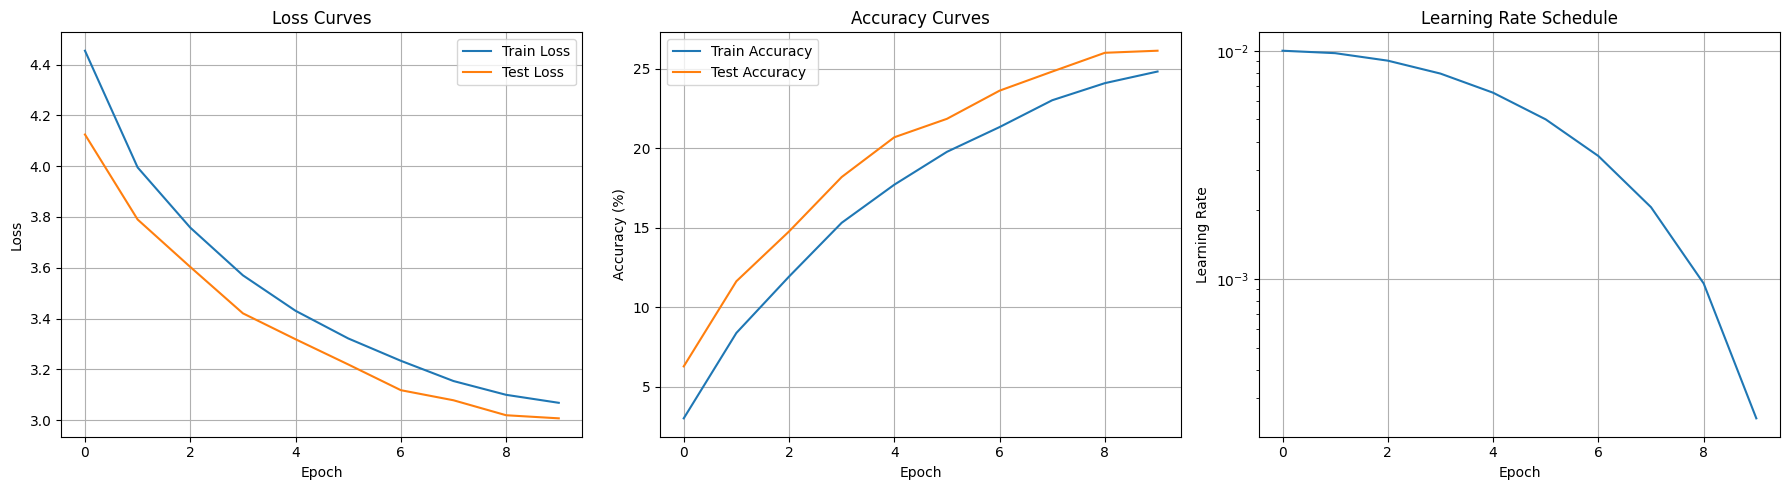

Centralized benchmark completed!


In [2]:
# colab test

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.models as models
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import pickle
import numpy as np
import random

print("PyTorch version:", torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seeding for reproducibility
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# transforms
train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])


# load data

def load_data(dataset_name="cifar100", batch_size=128, num_workers=2):

    if dataset_name.lower() == "cifar10":
        train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        num_classes = 10
    elif dataset_name.lower() == "cifar100":
        train_dataset = CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        test_dataset = CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        num_classes = 100
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    # data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )

    return train_loader, test_loader, num_classes


# model - LeNet5 from the paper [11]
class LeNet5(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet5, self).__init__()
    # Input: 3x32x32 (CIFAR has 3 color channels)
    self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # Output: 6x28x28
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 6x14x14
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Output: 16x10x10
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x5x5

    # fc layers
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def create_model(model_name, num_classes=10):
    if model_name.lower() == "lenet5":
        return LeNet5(num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")

# train
def train_epoch(model, train_loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  pbar = tqdm(train_loader, desc="Training")

  for inputs, labels in pbar:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    # just a progress bar
    pbar.set_postfix({
      'loss': running_loss / total,
      'acc': 100. * correct / total
    })

  train_loss = running_loss / total
  train_acc = 100. * correct / total

  return train_loss, train_acc


# eval
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / total
    test_acc = 100. * correct / total

    return test_loss, test_acc


# train config
def train_centralized_model(
    model_name="lenet5",
    dataset_name="cifar100",
    batch_size=128,
    epochs=10,
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4,
    lr_scheduler="cosine",
    save_path="lenet5_model.pth"
):
    # load data
    train_loader, test_loader, num_classes = load_data(
        dataset_name=dataset_name,
        batch_size=batch_size
    )

    # model
    model = create_model(model_name, num_classes=num_classes)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )

    # lr
    if lr_scheduler == "step":
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[int(epochs * 0.5), int(epochs * 0.75)],
            gamma=0.1
        )
    elif lr_scheduler == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs
        )
    else:
        raise ValueError(f"Unknown scheduler: {lr_scheduler}")

    # training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'lr': []
    }

    # track best accuracy
    best_acc = 0.0

    # training loop
    for epoch in range(epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch [{epoch+1}/{epochs}] - Learning Rate: {current_lr:.6f}")

        # training for one epoch
        start_time = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_time = time.time() - start_time

        # evaluate on test set
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        # step learning rate scheduler
        scheduler.step()

        # stats
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, "
              f"Time: {train_time:.2f}s")

        # save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'test_acc': test_acc,
            }, save_path)
            print(f"New best model saved with accuracy: {test_acc:.2f}%")

        # update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['lr'].append(current_lr)

    # load best model
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded with accuracy: {checkpoint['test_acc']:.2f}%")

    return model, history

# visualization of model performance
def plot_training_history(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # plot the loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['test_loss'], label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss Curves')
    ax1.grid(True)

    # plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['test_acc'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Accuracy Curves')
    ax2.grid(True)

    # plot learning rate
    ax3.plot(history['lr'])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_yscale('log')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# run benchmark
def run_centralized_benchmark():
    # LeNet5 config
    config = {
        'model_name': 'lenet5',
        'dataset_name': 'cifar100',
        'batch_size': 128,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'weight_decay': 5e-4,
        'lr_scheduler': 'cosine',
        'save_path': 'lenet5_model.pth'
    }

    print(f"Running centralized benchmark with {config['model_name']} on {config['dataset_name']}...")

    # Train model
    model, history = train_centralized_model(**config)

    # Plot results
    plot_training_history(history)

    # Save history
    with open('lenet5_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    print("Centralized benchmark completed!")

    return model, history

# run it
model, history = run_centralized_benchmark()
